In [1]:
import dut_func as dut
import serial
import time
import struct
import numpy as np
# from bitarray import bitarray
from bitstring import BitArray
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
import dut_a0 as a0

from misc import *

In [2]:
from dpe import DPE
dpe = DPE('COM7')

DAC initialized to a span from -10 V to 10 V
Setting vrefs to default


In [3]:
dpe.set_clock(50)

Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz


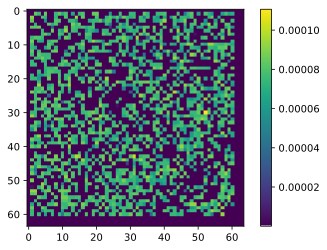

In [4]:
plt.imshow(dpe.read(0))
plt.colorbar()

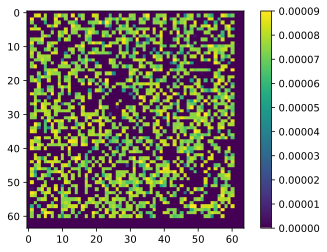

In [53]:
plt.imshow(dpe.read(0), clim=[0, 90e-6])
plt.colorbar()

In [5]:
from lib_data import *
import scipy.io as sio
mat_contents = sio.loadmat('Exported60Node_GraphNum0.mat')
CMat = mat_contents['A']

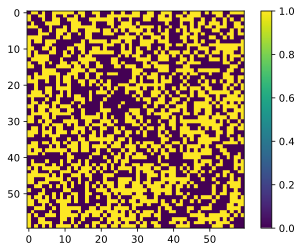

In [31]:
plt.imshow(CMat)
plt.colorbar()

In [6]:
def lin_corr(outputs, factors):
    result = np.zeros(outputs.shape)
    for c in range(outputs.shape[1]):
        result[:,c] = outputs[:,c] * factors[c][0] + factors[c][1]
        
    return result

In [7]:
from lib_data import *
import scipy.io as sio
mat_contents = sio.loadmat('Exported60Node_GraphNum0.mat')
CMat = mat_contents['A']

def lin_corr(outputs, factors):
    result = np.zeros(outputs.shape)
    for c in range(outputs.shape[1]):
        result[:,c] = outputs[:,c] * factors[c][0] + factors[c][1]
        
    return result

import dut_func as dut
import time
import struct
import matplotlib
import matplotlib.pyplot as plt
from dpe import DPE
from lib_data import *
from lib_nn_dpe import NN_dpe
from IPython import display

#from lib_data import *
#import scipy.io as sio
#mat_contents = sio.loadmat('Exported60Node_GraphNum0.mat')
#CMat = mat_contents['A']

dpe.N_BIT = 1

numTests = 200
appliedVector1 = np.zeros((64,numTests))
appliedVector2 = np.zeros((64,numTests))
randomVector = np.random.randint(2, size=(60,numTests))

appliedVector1[1:61,:] = randomVector[:,:]
appliedVector2[1:61,:] = 1-randomVector[:,:]
neuronVector = appliedVector1[1:61,:] - appliedVector2[1:61,:]

output1  = dpe.multiply_w_delay(0, appliedVector1, c_sel=[1, 61], mode=1, debug=False, delay=5)
#output2  = dpe.multiply_w_delay(0, appliedVector2, c_sel=[1, 61], mode=1, debug=False, delay=5)
output = output1
#SW_output = neuronVector * CMat
#SW_output = np.matmul(neuronVector, CMat)
SW_output = (CMat.T @ appliedVector1[1:61,:]).T 

for c in range(60):
    y = output[:,c]
    x = SW_output[:,c]
    plt.plot(x,y,'.')

new_lin_corr2 = []
for c in range(60):
    new_lin_corr2.append( np.polyfit(output[:,c], SW_output[:,c], 1))

output_corr = lin_corr(output, new_lin_corr2)
error = output_corr - SW_output
for c in range(60):
    x = SW_output[:,c]
    y = output_corr[:,c]    
    plt.plot(x,y,'.')

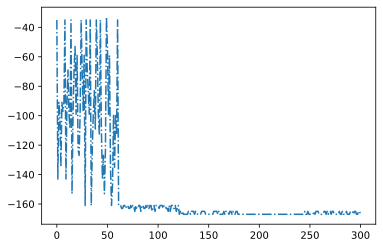

In [8]:
#Function to run the hopfield network

numCycles = 5
threshold = 0
noise = 0
numCols = 60

energyHistory = np.zeros(numCycles*numCols+1)
appliedVector1 = np.zeros((64,1))
appliedVector2 = np.zeros((64,1))

randomVector = np.random.randint(2, size=(60,1))

appliedVector1[1:61,:] = randomVector[:,:]
appliedVector2[1:61,:] = 1-randomVector[:,:]
neuronVector = appliedVector1[1:61,:] - appliedVector2[1:61,:]

energyHistory[0]= 0.5*np.dot(neuronVector.T, (CMat @ neuronVector))
neuronVectorHistory = np.zeros((60,numCycles*numCols+1))
#neuronVectorHistory[:,0] = neuronVector
neuronVectorHistory[:,0] = appliedVector1[1:61,0] - appliedVector2[1:61,0]

for cc in np.arange(numCycles):
    randOrderColumns = np.arange(60)
    np.random.shuffle(randOrderColumns)
    for ii in randOrderColumns:
        output1  = dpe.multiply_w_delay(0, appliedVector1, c_sel=[1, 61], mode=1, debug=False, delay=5)
        output2  = dpe.multiply_w_delay(0, appliedVector2, c_sel=[1, 61], mode=1, debug=False, delay=5)
        #output = output1[0,ii] - output2[0,ii]
        output_corr = noise - lin_corr(output1, new_lin_corr2) + lin_corr(output2, new_lin_corr2)
        if (output_corr[0,ii] >= threshold):
            appliedVector1[1+ii,0] = 1
            appliedVector2[1+ii,0] = 0
            neuronVector[ii] = 1
        else:
            appliedVector1[1+ii,0] = 0
            appliedVector2[1+ii,0] = 1
            neuronVector[ii] = -1
        energyHistory[60*cc+ii+1]= 0.5*np.dot(neuronVector.T, (CMat @ neuronVector))
        neuronVectorHistory[:,60*cc+ii+1] = neuronVector[:,0]

plt.plot(energyHistory,'-.')

In [9]:
from lib_data import *
save_workspace(vars(), note='FtC_HNN_5cycles0noise')

Saving In(<class 'list'>), Out(<class 'dict'>), PIC_PINS(<class 'dict'>), DAC_CH(<class 'dict'>), DAC_SPAN(<class 'dict'>), REFCLKO(<class 'dict'>), mat_contents(<class 'dict'>), CMat(<class 'numpy.ndarray'>), numTests(<class 'int'>), appliedVector1(<class 'numpy.ndarray'>), appliedVector2(<class 'numpy.ndarray'>), randomVector(<class 'numpy.ndarray'>), neuronVector(<class 'numpy.ndarray'>), output1(<class 'numpy.ndarray'>), output(<class 'numpy.ndarray'>), SW_output(<class 'numpy.ndarray'>), c(<class 'int'>), y(<class 'numpy.ndarray'>), x(<class 'numpy.ndarray'>), new_lin_corr2(<class 'list'>), output_corr(<class 'numpy.ndarray'>), error(<class 'numpy.ndarray'>), numCycles(<class 'int'>), threshold(<class 'int'>), noise(<class 'int'>), numCols(<class 'int'>), energyHistory(<class 'numpy.ndarray'>), neuronVectorHistory(<class 'numpy.ndarray'>), randOrderColumns(<class 'numpy.ndarray'>), output2(<class 'numpy.ndarray'>), to 20191024-001225-FtC_HNN_5cycles0noise.pkl
Saving In(<class 'lis

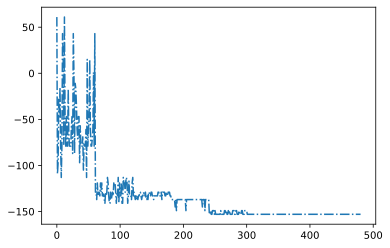

In [10]:
#Function to run the hopfield network

numCycles = 8
threshold = 0
noise = 0
numCols = 60

energyHistory = np.zeros(numCycles*numCols+1)
appliedVector1 = np.zeros((64,1))
appliedVector2 = np.zeros((64,1))

randomVector = np.random.randint(2, size=(60,1))

appliedVector1[1:61,:] = randomVector[:,:]
appliedVector2[1:61,:] = 1-randomVector[:,:]
neuronVector = appliedVector1[1:61,:] - appliedVector2[1:61,:]

energyHistory[0]= 0.5*np.dot(neuronVector.T, (CMat @ neuronVector))
neuronVectorHistory = np.zeros((60,numCycles*numCols+1))
#neuronVectorHistory[:,0] = neuronVector
neuronVectorHistory[:,0] = appliedVector1[1:61,0] - appliedVector2[1:61,0]

for cc in np.arange(numCycles):
    randOrderColumns = np.arange(60)
    np.random.shuffle(randOrderColumns)
    for ii in randOrderColumns:
        output1  = dpe.multiply_w_delay(0, appliedVector1, c_sel=[1, 61], mode=1, debug=False, delay=5)
        output2  = dpe.multiply_w_delay(0, appliedVector2, c_sel=[1, 61], mode=1, debug=False, delay=5)
        #output = output1[0,ii] - output2[0,ii]
        output_corr = noise - lin_corr(output1, new_lin_corr2) + lin_corr(output2, new_lin_corr2)
        if (output_corr[0,ii] >= threshold):
            appliedVector1[1+ii,0] = 1
            appliedVector2[1+ii,0] = 0
            neuronVector[ii] = 1
        else:
            appliedVector1[1+ii,0] = 0
            appliedVector2[1+ii,0] = 1
            neuronVector[ii] = -1
        energyHistory[60*cc+ii+1]= 0.5*np.dot(neuronVector.T, (CMat @ neuronVector))
        neuronVectorHistory[:,60*cc+ii+1] = neuronVector[:,0]

plt.plot(energyHistory,'-.')

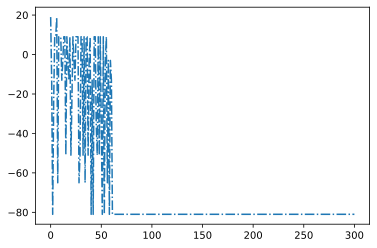

In [10]:
#Function to run the hopfield network

numCycles = 5
threshold = 0
noise = 0
numCols = 60
hystereticThresh = 5

energyHistory = np.zeros(numCycles*numCols+1)
appliedVector1 = np.zeros((64,1))
appliedVector2 = np.zeros((64,1))

randomVector = np.random.randint(2, size=(60,1))
initVector = randomVector

appliedVector1[1:61,:] = randomVector[:,:]
appliedVector2[1:61,:] = 1-randomVector[:,:]
neuronVector = appliedVector1[1:61,:] - appliedVector2[1:61,:]

energyHistory[0]= 0.5*np.dot(neuronVector.T, (CMat @ neuronVector))
neuronVectorHistory = np.zeros((60,numCycles*numCols+1))
#neuronVectorHistory[:,0] = neuronVector
neuronVectorHistory[:,0] = appliedVector1[1:61,0] - appliedVector2[1:61,0]

for cc in np.arange(numCycles):
    randOrderColumns = np.arange(60)
    np.random.shuffle(randOrderColumns)
    threshVector = threshold - np.ones(60)*hystereticThresh*neuronVector
    for ii in randOrderColumns:
        output1  = dpe.multiply_w_delay(0, appliedVector1, c_sel=[1, 61], mode=1, debug=False, delay=5)
        output2  = dpe.multiply_w_delay(0, appliedVector2, c_sel=[1, 61], mode=1, debug=False, delay=5)
        #output = output1[0,ii] - output2[0,ii]
        output_corr = noise - lin_corr(output1, new_lin_corr2) + lin_corr(output2, new_lin_corr2)
        if (output_corr[0,ii] >= threshVector[ii,0]):
            appliedVector1[1+ii,0] = 1
            appliedVector2[1+ii,0] = 0
            neuronVector[ii] = 1
        else:
            appliedVector1[1+ii,0] = 0
            appliedVector2[1+ii,0] = 1
            neuronVector[ii] = -1
        energyHistory[60*cc+ii+1]= 0.5*np.dot(neuronVector.T, (CMat @ neuronVector))
        neuronVectorHistory[:,60*cc+ii+1] = neuronVector[:,0]

plt.plot(energyHistory,'-.')

numCycles = 5
threshold = 0
noise = 0
numCols = 60
hystereticThresh = 0

energyHistory2 = np.zeros(numCycles*numCols+1)
appliedVector1 = np.zeros((64,1))
appliedVector2 = np.zeros((64,1))


randomVector = initVector

appliedVector1[1:61,:] = randomVector[:,:]
appliedVector2[1:61,:] = 1-randomVector[:,:]
neuronVector = appliedVector1[1:61,:] - appliedVector2[1:61,:]

energyHistory2[0]= 0.5*np.dot(neuronVector.T, (CMat @ neuronVector))
neuronVectorHistory = np.zeros((60,numCycles*numCols+1))
#neuronVectorHistory[:,0] = neuronVector
neuronVectorHistory[:,0] = appliedVector1[1:61,0] - appliedVector2[1:61,0]

for cc in np.arange(numCycles):
    randOrderColumns = np.arange(60)
    np.random.shuffle(randOrderColumns)
    threshVector = threshold - np.ones(60)*hystereticThresh*neuronVector
    for ii in randOrderColumns:
        output1  = dpe.multiply_w_delay(0, appliedVector1, c_sel=[1, 61], mode=1, debug=False, delay=5)
        output2  = dpe.multiply_w_delay(0, appliedVector2, c_sel=[1, 61], mode=1, debug=False, delay=5)
        #output = output1[0,ii] - output2[0,ii]
        output_corr = noise - lin_corr(output1, new_lin_corr2) + lin_corr(output2, new_lin_corr2)
        if (output_corr[0,ii] >= threshVector[ii,0]):
            appliedVector1[1+ii,0] = 1
            appliedVector2[1+ii,0] = 0
            neuronVector[ii] = 1
        else:
            appliedVector1[1+ii,0] = 0
            appliedVector2[1+ii,0] = 1
            neuronVector[ii] = -1
        energyHistory2[60*cc+ii+1]= 0.5*np.dot(neuronVector.T, (CMat @ neuronVector))
        neuronVectorHistory[:,60*cc+ii+1] = neuronVector[:,0]

#plt.plot(energyHistory2,'-.')

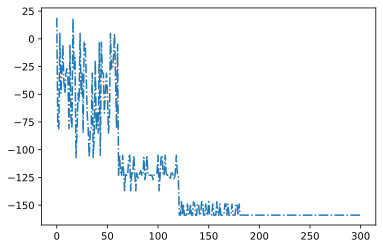

In [11]:
plt.plot(energyHistory2,'-.')

In [12]:
save_workspace(vars(), note='FtC_HNN_5cyclesSchmidt5_0')

Saving In(<class 'list'>), Out(<class 'dict'>), PIC_PINS(<class 'dict'>), DAC_CH(<class 'dict'>), DAC_SPAN(<class 'dict'>), REFCLKO(<class 'dict'>), mat_contents(<class 'dict'>), CMat(<class 'numpy.ndarray'>), numTests(<class 'int'>), appliedVector1(<class 'numpy.ndarray'>), appliedVector2(<class 'numpy.ndarray'>), randomVector(<class 'numpy.ndarray'>), neuronVector(<class 'numpy.ndarray'>), output1(<class 'numpy.ndarray'>), output(<class 'numpy.ndarray'>), SW_output(<class 'numpy.ndarray'>), c(<class 'int'>), y(<class 'numpy.ndarray'>), x(<class 'numpy.ndarray'>), new_lin_corr2(<class 'list'>), output_corr(<class 'numpy.ndarray'>), error(<class 'numpy.ndarray'>), numCycles(<class 'int'>), threshold(<class 'int'>), noise(<class 'int'>), numCols(<class 'int'>), energyHistory(<class 'numpy.ndarray'>), neuronVectorHistory(<class 'numpy.ndarray'>), randOrderColumns(<class 'numpy.ndarray'>), output2(<class 'numpy.ndarray'>), hystereticThresh(<class 'int'>), initVector(<class 'numpy.ndarray'

Saving In(<class 'list'>), Out(<class 'dict'>), PIC_PINS(<class 'dict'>), DAC_CH(<class 'dict'>), DAC_SPAN(<class 'dict'>), REFCLKO(<class 'dict'>), mat_contents(<class 'dict'>), CMat(<class 'numpy.ndarray'>), numTests(<class 'int'>), appliedVector1(<class 'numpy.ndarray'>), appliedVector2(<class 'numpy.ndarray'>), randomVector(<class 'numpy.ndarray'>), neuronVector(<class 'numpy.ndarray'>), output1(<class 'numpy.ndarray'>), output(<class 'numpy.ndarray'>), SW_output(<class 'numpy.ndarray'>), c(<class 'int'>), y(<class 'numpy.ndarray'>), x(<class 'numpy.ndarray'>), new_lin_corr2(<class 'list'>), output_corr(<class 'numpy.ndarray'>), error(<class 'numpy.ndarray'>), numCycles(<class 'int'>), threshold(<class 'int'>), noise(<class 'int'>), numCols(<class 'int'>), energyHistory(<class 'numpy.ndarray'>), neuronVectorHistory(<class 'numpy.ndarray'>), randOrderColumns(<class 'numpy.ndarray'>), output2(<class 'numpy.ndarray'>), hystereticThresh(<class 'numpy.ndarray'>), initVector(<class 'nump

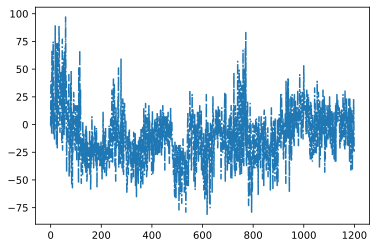

In [24]:
#Function to run the hopfield network

numCycles = 20
numTrials = 5
numSchmidt = 8
SchmidtVals = np.linspace(-12,12,numSchmidt)
threshold = 0
noise = 0
numCols = 60


energyHistory = np.zeros((numCycles*numCols+1, numTrials, numSchmidt))
neuronVectorHistory = np.zeros((numCols,numCycles*numCols+1, numTrials, numSchmidt))
appliedVector1 = np.zeros((64,1))
appliedVector2 = np.zeros((64,1))

for tt in np.arange(numTrials):

    randomVector = np.random.randint(2, size=(60,1))
    initVector = randomVector
    
    for ss in np.arange(numSchmidt):
        Schmidt = SchmidtVals[ss]
        appliedVector1[1:61,:] = initVector[:,:]
        appliedVector2[1:61,:] = 1-initVector[:,:]
        neuronVector = appliedVector1[1:61,:] - appliedVector2[1:61,:]

        energyHistory[0,tt,ss]= 0.5*np.dot(neuronVector.T, (CMat @ neuronVector))
        neuronVectorHistory[:,0,tt,ss] = appliedVector1[1:61,0] - appliedVector2[1:61,0]

        for cc in np.arange(numCycles):
            randOrderColumns = np.arange(60)
            np.random.shuffle(randOrderColumns)
            threshVector = threshold - np.ones(numCols)*Schmidt*neuronVector
            for ii in randOrderColumns:
                output1  = dpe.multiply_w_delay(0, appliedVector1, c_sel=[1, 61], mode=1, debug=False, delay=5)
                output2  = dpe.multiply_w_delay(0, appliedVector2, c_sel=[1, 61], mode=1, debug=False, delay=5)
                #output = output1[0,ii] - output2[0,ii]
                output_corr = noise - lin_corr(output1, new_lin_corr2) + lin_corr(output2, new_lin_corr2)
                if (output_corr[0,ii] >= threshVector[ii,0]):
                    appliedVector1[1+ii,0] = 1
                    appliedVector2[1+ii,0] = 0
                    neuronVector[ii] = 1
                else:
                    appliedVector1[1+ii,0] = 0
                    appliedVector2[1+ii,0] = 1
                    neuronVector[ii] = -1
                energyHistory[numCols*cc+ii+1,tt,ss]= 0.5*np.dot(neuronVector.T, (CMat @ neuronVector))
                neuronVectorHistory[:,numCols*cc+ii+1,tt,ss] = neuronVector[:,0]

plt.plot(energyHistory[:,0,0],'-.')
save_workspace(vars(), note='FtC_HNN_20cyc_5trials_8Schmidt')

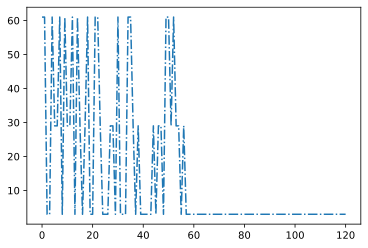

In [23]:
plt.plot(energyHistory[:,0,1],'-.')

Saving In(<class 'list'>), Out(<class 'dict'>), PIC_PINS(<class 'dict'>), DAC_CH(<class 'dict'>), DAC_SPAN(<class 'dict'>), REFCLKO(<class 'dict'>), mat_contents(<class 'dict'>), CMat(<class 'numpy.ndarray'>), numTests(<class 'int'>), appliedVector1(<class 'numpy.ndarray'>), appliedVector2(<class 'numpy.ndarray'>), randomVector(<class 'numpy.ndarray'>), neuronVector(<class 'numpy.ndarray'>), output1(<class 'numpy.ndarray'>), output(<class 'numpy.ndarray'>), SW_output(<class 'numpy.ndarray'>), c(<class 'int'>), y(<class 'numpy.ndarray'>), x(<class 'numpy.ndarray'>), new_lin_corr2(<class 'list'>), output_corr(<class 'numpy.ndarray'>), error(<class 'numpy.ndarray'>), numCycles(<class 'int'>), threshold(<class 'int'>), noise(<class 'int'>), numCols(<class 'int'>), energyHistory(<class 'numpy.ndarray'>), neuronVectorHistory(<class 'numpy.ndarray'>), randOrderColumns(<class 'numpy.ndarray'>), output2(<class 'numpy.ndarray'>), hystereticThresh(<class 'numpy.ndarray'>), initVector(<class 'nump

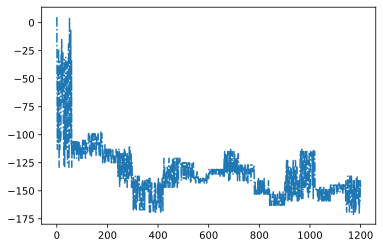

In [28]:
#Function to run the hopfield network

numCycles = 20
numTrials = 5
numSchmidt = 6
SchmidtVals = np.linspace(-2.,2.,numSchmidt)
threshold = 0
noise = 0
numCols = 60


energyHistory = np.zeros((numCycles*numCols+1, numTrials, numSchmidt))
neuronVectorHistory = np.zeros((numCols,numCycles*numCols+1, numTrials, numSchmidt))
appliedVector1 = np.zeros((64,1))
appliedVector2 = np.zeros((64,1))

for tt in np.arange(numTrials):

    randomVector = np.random.randint(2, size=(60,1))
    initVector = randomVector
    
    for ss in np.arange(numSchmidt):
        Schmidt = SchmidtVals[ss]
        appliedVector1[1:61,:] = initVector[:,:]
        appliedVector2[1:61,:] = 1-initVector[:,:]
        neuronVector = appliedVector1[1:61,:] - appliedVector2[1:61,:]

        energyHistory[0,tt,ss]= 0.5*np.dot(neuronVector.T, (CMat @ neuronVector))
        neuronVectorHistory[:,0,tt,ss] = appliedVector1[1:61,0] - appliedVector2[1:61,0]

        for cc in np.arange(numCycles):
            randOrderColumns = np.arange(60)
            np.random.shuffle(randOrderColumns)
            threshVector = threshold - np.ones(numCols)*Schmidt*neuronVector
            for ii in randOrderColumns:
                output1  = dpe.multiply_w_delay(0, appliedVector1, c_sel=[1, 61], mode=1, debug=False, delay=5)
                output2  = dpe.multiply_w_delay(0, appliedVector2, c_sel=[1, 61], mode=1, debug=False, delay=5)
                #output = output1[0,ii] - output2[0,ii]
                output_corr = noise - lin_corr(output1, new_lin_corr2) + lin_corr(output2, new_lin_corr2)
                if (output_corr[0,ii] >= threshVector[ii,0]):
                    appliedVector1[1+ii,0] = 1
                    appliedVector2[1+ii,0] = 0
                    neuronVector[ii] = 1
                else:
                    appliedVector1[1+ii,0] = 0
                    appliedVector2[1+ii,0] = 1
                    neuronVector[ii] = -1
                energyHistory[numCols*cc+ii+1,tt,ss]= 0.5*np.dot(neuronVector.T, (CMat @ neuronVector))
                neuronVectorHistory[:,numCols*cc+ii+1,tt,ss] = neuronVector[:,0]

plt.plot(energyHistory[:,0,0],'-.')
save_workspace(vars(), note='FtC_HNN_20cyc_5trials_6Schmidt')

In [29]:
numSchmidt = 6
SchmidtVals = np.linspace(-2.,2.,numSchmidt)
print(SchmidtVals)
SchmidtVals = [-4, -3, 3, 4]
print(SchmidtVals)

[-2.  -1.2 -0.4  0.4  1.2  2. ]
[-4, -3, 3, 4]


Saving In(<class 'list'>), Out(<class 'dict'>), PIC_PINS(<class 'dict'>), DAC_CH(<class 'dict'>), DAC_SPAN(<class 'dict'>), REFCLKO(<class 'dict'>), mat_contents(<class 'dict'>), CMat(<class 'numpy.ndarray'>), numTests(<class 'int'>), appliedVector1(<class 'numpy.ndarray'>), appliedVector2(<class 'numpy.ndarray'>), randomVector(<class 'numpy.ndarray'>), neuronVector(<class 'numpy.ndarray'>), output1(<class 'numpy.ndarray'>), output(<class 'numpy.ndarray'>), SW_output(<class 'numpy.ndarray'>), c(<class 'int'>), y(<class 'numpy.ndarray'>), x(<class 'numpy.ndarray'>), new_lin_corr2(<class 'list'>), output_corr(<class 'numpy.ndarray'>), error(<class 'numpy.ndarray'>), numCycles(<class 'int'>), threshold(<class 'int'>), noise(<class 'int'>), numCols(<class 'int'>), energyHistory(<class 'numpy.ndarray'>), neuronVectorHistory(<class 'numpy.ndarray'>), randOrderColumns(<class 'numpy.ndarray'>), output2(<class 'numpy.ndarray'>), hystereticThresh(<class 'numpy.ndarray'>), initVector(<class 'nump

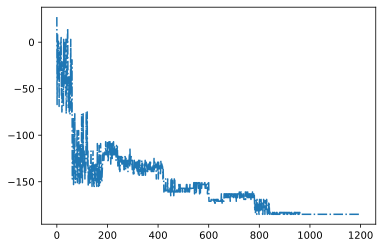

In [30]:
#Function to run the hopfield network

numCycles = 20
numTrials = 6
numSchmidt = 3
startSchmidtVals = [-3.5, -3, -2.5] 
endSchmidtVals = [1, 1.5, 2] 
threshold = 0
noise = 0
numCols = 60

energyHistory = np.zeros((numCycles*numCols+1, numTrials, numSchmidt))
neuronVectorHistory = np.zeros((numCols,numCycles*numCols+1, numTrials, numSchmidt))
appliedVector1 = np.zeros((64,1))
appliedVector2 = np.zeros((64,1))

for tt in np.arange(numTrials):

    randomVector = np.random.randint(2, size=(60,1))
    initVector = randomVector
    
    for ss in np.arange(numSchmidt):
        SchmidtCycleVector = np.linspace(startSchmidtVals[ss], endSchmidtVals[ss], numCycles)
        appliedVector1[1:61,:] = initVector[:,:]
        appliedVector2[1:61,:] = 1-initVector[:,:]
        neuronVector = appliedVector1[1:61,:] - appliedVector2[1:61,:]

        energyHistory[0,tt,ss]= 0.5*np.dot(neuronVector.T, (CMat @ neuronVector))
        neuronVectorHistory[:,0,tt,ss] = appliedVector1[1:61,0] - appliedVector2[1:61,0]

        for cc in np.arange(numCycles):
            randOrderColumns = np.arange(60)
            np.random.shuffle(randOrderColumns)
            threshVector = threshold - np.ones(numCols)*SchmidtCycleVector[cc]*neuronVector
            for ii in randOrderColumns:
                output1  = dpe.multiply_w_delay(0, appliedVector1, c_sel=[1, 61], mode=1, debug=False, delay=5)
                output2  = dpe.multiply_w_delay(0, appliedVector2, c_sel=[1, 61], mode=1, debug=False, delay=5)
                #output = output1[0,ii] - output2[0,ii]
                output_corr = noise - lin_corr(output1, new_lin_corr2) + lin_corr(output2, new_lin_corr2)
                if (output_corr[0,ii] >= threshVector[ii,0]):
                    appliedVector1[1+ii,0] = 1
                    appliedVector2[1+ii,0] = 0
                    neuronVector[ii] = 1
                else:
                    appliedVector1[1+ii,0] = 0
                    appliedVector2[1+ii,0] = 1
                    neuronVector[ii] = -1
                energyHistory[numCols*cc+ii+1,tt,ss]= 0.5*np.dot(neuronVector.T, (CMat @ neuronVector))
                neuronVectorHistory[:,numCols*cc+ii+1,tt,ss] = neuronVector[:,0]

plt.plot(energyHistory[:,0,0],'-.')
save_workspace(vars(), note='FtC_HNN_20cyc_6trials_3SchmidtRampDown')

Saving In(<class 'list'>), Out(<class 'dict'>), PIC_PINS(<class 'dict'>), DAC_CH(<class 'dict'>), DAC_SPAN(<class 'dict'>), REFCLKO(<class 'dict'>), mat_contents(<class 'dict'>), CMat(<class 'numpy.ndarray'>), numTests(<class 'int'>), appliedVector1(<class 'numpy.ndarray'>), appliedVector2(<class 'numpy.ndarray'>), randomVector(<class 'numpy.ndarray'>), neuronVector(<class 'numpy.ndarray'>), output1(<class 'numpy.ndarray'>), output(<class 'numpy.ndarray'>), SW_output(<class 'numpy.ndarray'>), c(<class 'int'>), y(<class 'numpy.ndarray'>), x(<class 'numpy.ndarray'>), new_lin_corr2(<class 'list'>), output_corr(<class 'numpy.ndarray'>), error(<class 'numpy.ndarray'>), numCycles(<class 'int'>), threshold(<class 'int'>), noise(<class 'int'>), numCols(<class 'int'>), energyHistory(<class 'numpy.ndarray'>), neuronVectorHistory(<class 'numpy.ndarray'>), randOrderColumns(<class 'numpy.ndarray'>), output2(<class 'numpy.ndarray'>), hystereticThresh(<class 'numpy.ndarray'>), initVector(<class 'nump

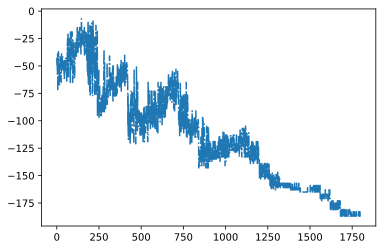

In [39]:
#Function to run the hopfield network

numCycles = 30
numTrials = 6
#numSchmidt = 3
startSchmidtVals = np.linspace(-5, 0, 4) #[-3.5, -3, -2.5] 
endSchmidtVals = np.linspace(0, 3, 4) #[1, 1.5, 2] 
numStartSchmidt = np.size(startSchmidtVals)
numEndSchmidt = np.size(endSchmidtVals)

threshold = 0
noise = 0
numCols = 60

energyHistory = np.zeros((numCycles*numCols+1, numTrials, numStartSchmidt, numEndSchmidt ))
neuronVectorHistory = np.zeros((numCols,numCycles*numCols+1, numTrials, numStartSchmidt, numEndSchmidt))
appliedVector1 = np.zeros((64,1))
appliedVector2 = np.zeros((64,1))

for tt in np.arange(numTrials):

    randomVector = np.random.randint(2, size=(60,1))
    initVector = randomVector
    
    for ss in np.arange(numStartSchmidt):
        for se in np.arange(numEndSchmidt):
            SchmidtCycleVector = np.linspace(startSchmidtVals[ss], endSchmidtVals[se], numCycles)
            appliedVector1[1:61,:] = initVector[:,:]
            appliedVector2[1:61,:] = 1-initVector[:,:]
            neuronVector = appliedVector1[1:61,:] - appliedVector2[1:61,:]

            energyHistory[0,tt,ss,se]= 0.5*np.dot(neuronVector.T, (CMat @ neuronVector))
            neuronVectorHistory[:,0,tt,ss,se] = appliedVector1[1:61,0] - appliedVector2[1:61,0]

            for cc in np.arange(numCycles):
                randOrderColumns = np.arange(60)
                np.random.shuffle(randOrderColumns)
                threshVector = threshold - np.ones(numCols)*SchmidtCycleVector[cc]*neuronVector
                for ii in randOrderColumns:
                    output1  = dpe.multiply_w_delay(0, appliedVector1, c_sel=[1, 61], mode=1, debug=False, delay=5)
                    output2  = dpe.multiply_w_delay(0, appliedVector2, c_sel=[1, 61], mode=1, debug=False, delay=5)
                    #output = output1[0,ii] - output2[0,ii]
                    output_corr = noise - lin_corr(output1, new_lin_corr2) + lin_corr(output2, new_lin_corr2)
                    if (output_corr[0,ii] >= threshVector[ii,0]):
                        appliedVector1[1+ii,0] = 1
                        appliedVector2[1+ii,0] = 0
                        neuronVector[ii] = 1
                    else:
                        appliedVector1[1+ii,0] = 0
                        appliedVector2[1+ii,0] = 1
                        neuronVector[ii] = -1
                    energyHistory[numCols*cc+ii+1,tt,ss,se]= 0.5*np.dot(neuronVector.T, (CMat @ neuronVector))
                    neuronVectorHistory[:,numCols*cc+ii+1,tt,ss,se] = neuronVector[:,0]

plt.plot(energyHistory[:,0,0,0],'-.')
save_workspace(vars(), note='FtC_HNN_30cyc_6trials_16SchmidtRampDown')

Saving In(<class 'list'>), Out(<class 'dict'>), PIC_PINS(<class 'dict'>), DAC_CH(<class 'dict'>), DAC_SPAN(<class 'dict'>), REFCLKO(<class 'dict'>), mat_contents(<class 'dict'>), CMat(<class 'numpy.ndarray'>), numTests(<class 'int'>), appliedVector1(<class 'numpy.ndarray'>), appliedVector2(<class 'numpy.ndarray'>), randomVector(<class 'numpy.ndarray'>), neuronVector(<class 'numpy.ndarray'>), output1(<class 'numpy.ndarray'>), output(<class 'numpy.ndarray'>), SW_output(<class 'numpy.ndarray'>), c(<class 'int'>), y(<class 'numpy.ndarray'>), x(<class 'numpy.ndarray'>), new_lin_corr2(<class 'list'>), output_corr(<class 'numpy.ndarray'>), error(<class 'numpy.ndarray'>), numCycles(<class 'int'>), threshold(<class 'int'>), noise(<class 'int'>), numCols(<class 'int'>), energyHistory(<class 'numpy.ndarray'>), neuronVectorHistory(<class 'numpy.ndarray'>), randOrderColumns(<class 'numpy.ndarray'>), output2(<class 'numpy.ndarray'>), hystereticThresh(<class 'numpy.ndarray'>), initVector(<class 'nump

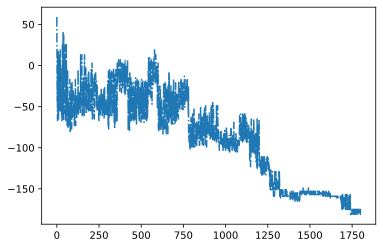

In [40]:
#Function to run the hopfield network

numCycles = 30
numTrials = 6
#numSchmidt = 3
startSchmidtVals = np.linspace(-7, -5, 3) #[-3.5, -3, -2.5] 
endSchmidtVals = np.linspace(0, 1.5, 3) #[1, 1.5, 2] 
numStartSchmidt = np.size(startSchmidtVals)
numEndSchmidt = np.size(endSchmidtVals)

threshold = 0
noise = 0
numCols = 60

energyHistory = np.zeros((numCycles*numCols+1, numTrials, numStartSchmidt, numEndSchmidt ))
neuronVectorHistory = np.zeros((numCols,numCycles*numCols+1, numTrials, numStartSchmidt, numEndSchmidt))
appliedVector1 = np.zeros((64,1))
appliedVector2 = np.zeros((64,1))

for tt in np.arange(numTrials):

    randomVector = np.random.randint(2, size=(60,1))
    initVector = randomVector
    
    for ss in np.arange(numStartSchmidt):
        for se in np.arange(numEndSchmidt):
            SchmidtCycleVector = np.linspace(startSchmidtVals[ss], endSchmidtVals[se], numCycles)
            appliedVector1[1:61,:] = initVector[:,:]
            appliedVector2[1:61,:] = 1-initVector[:,:]
            neuronVector = appliedVector1[1:61,:] - appliedVector2[1:61,:]

            energyHistory[0,tt,ss,se]= 0.5*np.dot(neuronVector.T, (CMat @ neuronVector))
            neuronVectorHistory[:,0,tt,ss,se] = appliedVector1[1:61,0] - appliedVector2[1:61,0]

            for cc in np.arange(numCycles):
                randOrderColumns = np.arange(60)
                np.random.shuffle(randOrderColumns)
                threshVector = threshold - np.ones(numCols)*SchmidtCycleVector[cc]*neuronVector
                for ii in randOrderColumns:
                    output1  = dpe.multiply_w_delay(0, appliedVector1, c_sel=[1, 61], mode=1, debug=False, delay=5)
                    output2  = dpe.multiply_w_delay(0, appliedVector2, c_sel=[1, 61], mode=1, debug=False, delay=5)
                    #output = output1[0,ii] - output2[0,ii]
                    output_corr = noise - lin_corr(output1, new_lin_corr2) + lin_corr(output2, new_lin_corr2)
                    if (output_corr[0,ii] >= threshVector[ii,0]):
                        appliedVector1[1+ii,0] = 1
                        appliedVector2[1+ii,0] = 0
                        neuronVector[ii] = 1
                    else:
                        appliedVector1[1+ii,0] = 0
                        appliedVector2[1+ii,0] = 1
                        neuronVector[ii] = -1
                    energyHistory[numCols*cc+ii+1,tt,ss,se]= 0.5*np.dot(neuronVector.T, (CMat @ neuronVector))
                    neuronVectorHistory[:,numCols*cc+ii+1,tt,ss,se] = neuronVector[:,0]

plt.plot(energyHistory[:,0,0,0],'-.')
save_workspace(vars(), note='FtC_HNN_30cyc_6trials_9SchmidtRampDown')

Saving In(<class 'list'>), Out(<class 'dict'>), PIC_PINS(<class 'dict'>), DAC_CH(<class 'dict'>), DAC_SPAN(<class 'dict'>), REFCLKO(<class 'dict'>), mat_contents(<class 'dict'>), CMat(<class 'numpy.ndarray'>), numTests(<class 'int'>), appliedVector1(<class 'numpy.ndarray'>), appliedVector2(<class 'numpy.ndarray'>), randomVector(<class 'numpy.ndarray'>), neuronVector(<class 'numpy.ndarray'>), output1(<class 'numpy.ndarray'>), output(<class 'numpy.ndarray'>), SW_output(<class 'numpy.ndarray'>), c(<class 'int'>), y(<class 'numpy.ndarray'>), x(<class 'numpy.ndarray'>), new_lin_corr2(<class 'list'>), output_corr(<class 'numpy.ndarray'>), error(<class 'numpy.ndarray'>), numCycles(<class 'int'>), threshold(<class 'int'>), noise(<class 'int'>), numCols(<class 'int'>), energyHistory(<class 'numpy.ndarray'>), neuronVectorHistory(<class 'numpy.ndarray'>), randOrderColumns(<class 'numpy.ndarray'>), output2(<class 'numpy.ndarray'>), hystereticThresh(<class 'numpy.ndarray'>), initVector(<class 'nump

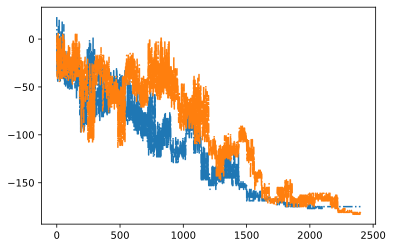

In [45]:
#Function to run the hopfield network

numCycles = 40
numTrials = 14

startSchmidtVals = np.linspace(-5, -5, 1) 
endSchmidtVals = np.linspace(0.75, 1.5, 4) 
numStartSchmidt = np.size(startSchmidtVals)
numEndSchmidt = np.size(endSchmidtVals)

threshold = 0
noise = 0
numCols = 60

energyHistory = np.zeros((numCycles*numCols+1, numTrials, numStartSchmidt, numEndSchmidt ))
neuronVectorHistory = np.zeros((numCols,numCycles*numCols+1, numTrials, numStartSchmidt, numEndSchmidt))
appliedVector1 = np.zeros((64,1))
appliedVector2 = np.zeros((64,1))

for tt in np.arange(numTrials):

    randomVector = np.random.randint(2, size=(60,1))
    initVector = randomVector
    
    for ss in np.arange(numStartSchmidt):
        for se in np.arange(numEndSchmidt):
            SchmidtCycleVector = np.linspace(startSchmidtVals[ss], endSchmidtVals[se], numCycles)
            appliedVector1[1:61,:] = initVector[:,:]
            appliedVector2[1:61,:] = 1-initVector[:,:]
            neuronVector = appliedVector1[1:61,:] - appliedVector2[1:61,:]

            energyHistory[0,tt,ss,se]= 0.5*np.dot(neuronVector.T, (CMat @ neuronVector))
            neuronVectorHistory[:,0,tt,ss,se] = appliedVector1[1:61,0] - appliedVector2[1:61,0]

            for cc in np.arange(numCycles):
                randOrderColumns = np.arange(60)
                np.random.shuffle(randOrderColumns)
                threshVector = threshold - np.ones(numCols)*SchmidtCycleVector[cc]*neuronVector
                for ii in randOrderColumns:
                    output1  = dpe.multiply_w_delay(0, appliedVector1, c_sel=[1, 61], mode=1, debug=False, delay=5)
                    output2  = dpe.multiply_w_delay(0, appliedVector2, c_sel=[1, 61], mode=1, debug=False, delay=5)
                    #output = output1[0,ii] - output2[0,ii]
                    output_corr = noise - lin_corr(output1, new_lin_corr2) + lin_corr(output2, new_lin_corr2)
                    if (output_corr[0,ii] >= threshVector[ii,0]):
                        appliedVector1[1+ii,0] = 1
                        appliedVector2[1+ii,0] = 0
                        neuronVector[ii] = 1
                    else:
                        appliedVector1[1+ii,0] = 0
                        appliedVector2[1+ii,0] = 1
                        neuronVector[ii] = -1
                    energyHistory[numCols*cc+ii+1,tt,ss,se]= 0.5*np.dot(neuronVector.T, (CMat @ neuronVector))
                    neuronVectorHistory[:,numCols*cc+ii+1,tt,ss,se] = neuronVector[:,0]

plt.plot(energyHistory[:,0,0,0],'-.')
save_workspace(vars(), note='FtC_HNN_40cyc_14trials_4SchmidtRampDown')

#Function to run the hopfield network

numCycles = 40
numTrials = 14

startSchmidtVals = np.linspace(-6, -6, 1) 
endSchmidtVals = np.linspace(-0.3, 0.3, 4) 
numStartSchmidt = np.size(startSchmidtVals)
numEndSchmidt = np.size(endSchmidtVals)

threshold = 0
noise = 0
numCols = 60

energyHistory = np.zeros((numCycles*numCols+1, numTrials, numStartSchmidt, numEndSchmidt ))
neuronVectorHistory = np.zeros((numCols,numCycles*numCols+1, numTrials, numStartSchmidt, numEndSchmidt))
appliedVector1 = np.zeros((64,1))
appliedVector2 = np.zeros((64,1))

for tt in np.arange(numTrials):

    randomVector = np.random.randint(2, size=(60,1))
    initVector = randomVector
    
    for ss in np.arange(numStartSchmidt):
        for se in np.arange(numEndSchmidt):
            SchmidtCycleVector = np.linspace(startSchmidtVals[ss], endSchmidtVals[se], numCycles)
            appliedVector1[1:61,:] = initVector[:,:]
            appliedVector2[1:61,:] = 1-initVector[:,:]
            neuronVector = appliedVector1[1:61,:] - appliedVector2[1:61,:]

            energyHistory[0,tt,ss,se]= 0.5*np.dot(neuronVector.T, (CMat @ neuronVector))
            neuronVectorHistory[:,0,tt,ss,se] = appliedVector1[1:61,0] - appliedVector2[1:61,0]

            for cc in np.arange(numCycles):
                randOrderColumns = np.arange(60)
                np.random.shuffle(randOrderColumns)
                threshVector = threshold - np.ones(numCols)*SchmidtCycleVector[cc]*neuronVector
                for ii in randOrderColumns:
                    output1  = dpe.multiply_w_delay(0, appliedVector1, c_sel=[1, 61], mode=1, debug=False, delay=5)
                    output2  = dpe.multiply_w_delay(0, appliedVector2, c_sel=[1, 61], mode=1, debug=False, delay=5)
                    #output = output1[0,ii] - output2[0,ii]
                    output_corr = noise - lin_corr(output1, new_lin_corr2) + lin_corr(output2, new_lin_corr2)
                    if (output_corr[0,ii] >= threshVector[ii,0]):
                        appliedVector1[1+ii,0] = 1
                        appliedVector2[1+ii,0] = 0
                        neuronVector[ii] = 1
                    else:
                        appliedVector1[1+ii,0] = 0
                        appliedVector2[1+ii,0] = 1
                        neuronVector[ii] = -1
                    energyHistory[numCols*cc+ii+1,tt,ss,se]= 0.5*np.dot(neuronVector.T, (CMat @ neuronVector))
                    neuronVectorHistory[:,numCols*cc+ii+1,tt,ss,se] = neuronVector[:,0]

plt.plot(energyHistory[:,0,0,0],'-.')
save_workspace(vars(), note='FtC_HNN_40cyc_14trials_4SchmidtRampDown2')

In [48]:

# dut.drv.serUSB = 'COM19'
drv = dut.drv

ser = serial.Serial('COM7', 9600, timeout=2)
dut.connect(ser)
dut.power_on()
dut.reset_chip()
dut.reset_dpe()

Setting vrefs to default


In [52]:
dut.disconnect()

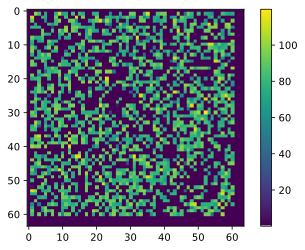

In [49]:
arr = 0
numRows = 64
numCols = 64
vRead = 0.2
vReadGate = 5.0
Gmap = np.zeros((numRows, numCols))
for rr in range(numRows):
        for cc in range(numCols):
            rdCurr = a0.read_single_int(vRead, vReadGate, array=arr, row=rr, col=cc, gain=-1) 
            #rdCurr = a0.pic_read_single(arr, rr, cc, Vread = vRead, gain=-1)
            Gmap[rr,cc] = 1e6*rdCurr/vRead
plt.imshow(Gmap)
plt.colorbar()

In [50]:
save_workspace(vars(), note='Hopfield60Node')

Saving In(<class 'list'>), Out(<class 'dict'>), PIC_PINS(<class 'dict'>), DAC_CH(<class 'dict'>), DAC_SPAN(<class 'dict'>), REFCLKO(<class 'dict'>), mat_contents(<class 'dict'>), CMat(<class 'numpy.ndarray'>), numTests(<class 'int'>), appliedVector1(<class 'numpy.ndarray'>), appliedVector2(<class 'numpy.ndarray'>), randomVector(<class 'numpy.ndarray'>), neuronVector(<class 'numpy.ndarray'>), output1(<class 'numpy.ndarray'>), output(<class 'numpy.ndarray'>), SW_output(<class 'numpy.ndarray'>), c(<class 'int'>), y(<class 'numpy.ndarray'>), x(<class 'numpy.ndarray'>), new_lin_corr2(<class 'list'>), output_corr(<class 'numpy.ndarray'>), error(<class 'numpy.ndarray'>), numCycles(<class 'int'>), threshold(<class 'int'>), noise(<class 'int'>), numCols(<class 'int'>), energyHistory(<class 'numpy.ndarray'>), neuronVectorHistory(<class 'numpy.ndarray'>), cc(<class 'int'>), randOrderColumns(<class 'numpy.ndarray'>), output2(<class 'numpy.ndarray'>), hystereticThresh(<class 'numpy.ndarray'>), init

Saving In(<class 'list'>), Out(<class 'dict'>), PIC_PINS(<class 'dict'>), DAC_CH(<class 'dict'>), DAC_SPAN(<class 'dict'>), REFCLKO(<class 'dict'>), mat_contents(<class 'dict'>), CMat(<class 'numpy.ndarray'>), numTests(<class 'int'>), appliedVector1(<class 'numpy.ndarray'>), appliedVector2(<class 'numpy.ndarray'>), randomVector(<class 'numpy.ndarray'>), neuronVector(<class 'numpy.ndarray'>), output1(<class 'numpy.ndarray'>), output(<class 'numpy.ndarray'>), SW_output(<class 'numpy.ndarray'>), c(<class 'int'>), y(<class 'numpy.ndarray'>), x(<class 'numpy.ndarray'>), new_lin_corr2(<class 'list'>), output_corr(<class 'numpy.ndarray'>), error(<class 'numpy.ndarray'>), numCycles(<class 'int'>), threshold(<class 'int'>), noise(<class 'int'>), numCols(<class 'int'>), energyHistory(<class 'numpy.ndarray'>), neuronVectorHistory(<class 'numpy.ndarray'>), randOrderColumns(<class 'numpy.ndarray'>), output2(<class 'numpy.ndarray'>), hystereticThresh(<class 'numpy.ndarray'>), initVector(<class 'nump

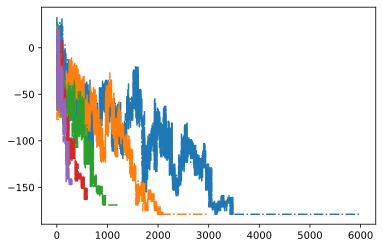

In [54]:
#Function to run the hopfield network

numCycles = 100
numTrials = 100

startSchmidtVals = np.linspace(-5, -5, 1) 
endSchmidtVals = np.linspace(0.85, 0.85, 1) 
numStartSchmidt = np.size(startSchmidtVals)
numEndSchmidt = np.size(endSchmidtVals)

threshold = 0
noise = 0
numCols = 60

energyHistory = np.zeros((numCycles*numCols+1, numTrials, numStartSchmidt, numEndSchmidt ))
neuronVectorHistory = np.zeros((numCols,numCycles*numCols+1, numTrials, numStartSchmidt, numEndSchmidt))
appliedVector1 = np.zeros((64,1))
appliedVector2 = np.zeros((64,1))

for tt in np.arange(numTrials):

    randomVector = np.random.randint(2, size=(60,1))
    initVector = randomVector
    
    for ss in np.arange(numStartSchmidt):
        for se in np.arange(numEndSchmidt):
            SchmidtCycleVector = np.linspace(startSchmidtVals[ss], endSchmidtVals[se], numCycles)
            appliedVector1[1:61,:] = initVector[:,:]
            appliedVector2[1:61,:] = 1-initVector[:,:]
            neuronVector = appliedVector1[1:61,:] - appliedVector2[1:61,:]

            energyHistory[0,tt,ss,se]= 0.5*np.dot(neuronVector.T, (CMat @ neuronVector))
            neuronVectorHistory[:,0,tt,ss,se] = appliedVector1[1:61,0] - appliedVector2[1:61,0]

            for cc in np.arange(numCycles):
                randOrderColumns = np.arange(60)
                np.random.shuffle(randOrderColumns)
                threshVector = threshold - np.ones(numCols)*SchmidtCycleVector[cc]*neuronVector
                for ii in randOrderColumns:
                    output1  = dpe.multiply_w_delay(0, appliedVector1, c_sel=[1, 61], mode=1, debug=False, delay=5)
                    output2  = dpe.multiply_w_delay(0, appliedVector2, c_sel=[1, 61], mode=1, debug=False, delay=5)
                    #output = output1[0,ii] - output2[0,ii]
                    output_corr = noise - lin_corr(output1, new_lin_corr2) + lin_corr(output2, new_lin_corr2)
                    if (output_corr[0,ii] >= threshVector[ii,0]):
                        appliedVector1[1+ii,0] = 1
                        appliedVector2[1+ii,0] = 0
                        neuronVector[ii] = 1
                    else:
                        appliedVector1[1+ii,0] = 0
                        appliedVector2[1+ii,0] = 1
                        neuronVector[ii] = -1
                    energyHistory[numCols*cc+ii+1,tt,ss,se]= 0.5*np.dot(neuronVector.T, (CMat @ neuronVector))
                    neuronVectorHistory[:,numCols*cc+ii+1,tt,ss,se] = neuronVector[:,0]

plt.plot(energyHistory[:,0,0,0],'-.')
save_workspace(vars(), note='FtC_HNN_100cyc_100trials_1SchmidtRampDown')

#Function to run the hopfield network

numCycles = 50
numTrials = 100

startSchmidtVals = np.linspace(-5, -5, 1) 
endSchmidtVals = np.linspace(0.85, 0.85, 1) 
numStartSchmidt = np.size(startSchmidtVals)
numEndSchmidt = np.size(endSchmidtVals)

threshold = 0
noise = 0
numCols = 60

energyHistory = np.zeros((numCycles*numCols+1, numTrials, numStartSchmidt, numEndSchmidt ))
neuronVectorHistory = np.zeros((numCols,numCycles*numCols+1, numTrials, numStartSchmidt, numEndSchmidt))
appliedVector1 = np.zeros((64,1))
appliedVector2 = np.zeros((64,1))

for tt in np.arange(numTrials):

    randomVector = np.random.randint(2, size=(60,1))
    initVector = randomVector
    
    for ss in np.arange(numStartSchmidt):
        for se in np.arange(numEndSchmidt):
            SchmidtCycleVector = np.linspace(startSchmidtVals[ss], endSchmidtVals[se], numCycles)
            appliedVector1[1:61,:] = initVector[:,:]
            appliedVector2[1:61,:] = 1-initVector[:,:]
            neuronVector = appliedVector1[1:61,:] - appliedVector2[1:61,:]

            energyHistory[0,tt,ss,se]= 0.5*np.dot(neuronVector.T, (CMat @ neuronVector))
            neuronVectorHistory[:,0,tt,ss,se] = appliedVector1[1:61,0] - appliedVector2[1:61,0]

            for cc in np.arange(numCycles):
                randOrderColumns = np.arange(60)
                np.random.shuffle(randOrderColumns)
                threshVector = threshold - np.ones(numCols)*SchmidtCycleVector[cc]*neuronVector
                for ii in randOrderColumns:
                    output1  = dpe.multiply_w_delay(0, appliedVector1, c_sel=[1, 61], mode=1, debug=False, delay=5)
                    output2  = dpe.multiply_w_delay(0, appliedVector2, c_sel=[1, 61], mode=1, debug=False, delay=5)
                    #output = output1[0,ii] - output2[0,ii]
                    output_corr = noise - lin_corr(output1, new_lin_corr2) + lin_corr(output2, new_lin_corr2)
                    if (output_corr[0,ii] >= threshVector[ii,0]):
                        appliedVector1[1+ii,0] = 1
                        appliedVector2[1+ii,0] = 0
                        neuronVector[ii] = 1
                    else:
                        appliedVector1[1+ii,0] = 0
                        appliedVector2[1+ii,0] = 1
                        neuronVector[ii] = -1
                    energyHistory[numCols*cc+ii+1,tt,ss,se]= 0.5*np.dot(neuronVector.T, (CMat @ neuronVector))
                    neuronVectorHistory[:,numCols*cc+ii+1,tt,ss,se] = neuronVector[:,0]

plt.plot(energyHistory[:,0,0,0],'-.')
save_workspace(vars(), note='FtC_HNN_50cyc_100trials_1SchmidtRampDown')

numCycles = 20
numTrials = 100

startSchmidtVals = np.linspace(-5, -5, 1) 
endSchmidtVals = np.linspace(0.85, 0.85, 1) 
numStartSchmidt = np.size(startSchmidtVals)
numEndSchmidt = np.size(endSchmidtVals)

threshold = 0
noise = 0
numCols = 60

energyHistory = np.zeros((numCycles*numCols+1, numTrials, numStartSchmidt, numEndSchmidt ))
neuronVectorHistory = np.zeros((numCols,numCycles*numCols+1, numTrials, numStartSchmidt, numEndSchmidt))
appliedVector1 = np.zeros((64,1))
appliedVector2 = np.zeros((64,1))

for tt in np.arange(numTrials):

    randomVector = np.random.randint(2, size=(60,1))
    initVector = randomVector
    
    for ss in np.arange(numStartSchmidt):
        for se in np.arange(numEndSchmidt):
            SchmidtCycleVector = np.linspace(startSchmidtVals[ss], endSchmidtVals[se], numCycles)
            appliedVector1[1:61,:] = initVector[:,:]
            appliedVector2[1:61,:] = 1-initVector[:,:]
            neuronVector = appliedVector1[1:61,:] - appliedVector2[1:61,:]

            energyHistory[0,tt,ss,se]= 0.5*np.dot(neuronVector.T, (CMat @ neuronVector))
            neuronVectorHistory[:,0,tt,ss,se] = appliedVector1[1:61,0] - appliedVector2[1:61,0]

            for cc in np.arange(numCycles):
                randOrderColumns = np.arange(60)
                np.random.shuffle(randOrderColumns)
                threshVector = threshold - np.ones(numCols)*SchmidtCycleVector[cc]*neuronVector
                for ii in randOrderColumns:
                    output1  = dpe.multiply_w_delay(0, appliedVector1, c_sel=[1, 61], mode=1, debug=False, delay=5)
                    output2  = dpe.multiply_w_delay(0, appliedVector2, c_sel=[1, 61], mode=1, debug=False, delay=5)
                    #output = output1[0,ii] - output2[0,ii]
                    output_corr = noise - lin_corr(output1, new_lin_corr2) + lin_corr(output2, new_lin_corr2)
                    if (output_corr[0,ii] >= threshVector[ii,0]):
                        appliedVector1[1+ii,0] = 1
                        appliedVector2[1+ii,0] = 0
                        neuronVector[ii] = 1
                    else:
                        appliedVector1[1+ii,0] = 0
                        appliedVector2[1+ii,0] = 1
                        neuronVector[ii] = -1
                    energyHistory[numCols*cc+ii+1,tt,ss,se]= 0.5*np.dot(neuronVector.T, (CMat @ neuronVector))
                    neuronVectorHistory[:,numCols*cc+ii+1,tt,ss,se] = neuronVector[:,0]

plt.plot(energyHistory[:,0,0,0],'-.')
save_workspace(vars(), note='FtC_HNN_20cyc_100trials_1SchmidtRampDown')

numCycles = 10
numTrials = 100

startSchmidtVals = np.linspace(-5, -5, 1) 
endSchmidtVals = np.linspace(0.85, 0.85, 1) 
numStartSchmidt = np.size(startSchmidtVals)
numEndSchmidt = np.size(endSchmidtVals)

threshold = 0
noise = 0
numCols = 60

energyHistory = np.zeros((numCycles*numCols+1, numTrials, numStartSchmidt, numEndSchmidt ))
neuronVectorHistory = np.zeros((numCols,numCycles*numCols+1, numTrials, numStartSchmidt, numEndSchmidt))
appliedVector1 = np.zeros((64,1))
appliedVector2 = np.zeros((64,1))

for tt in np.arange(numTrials):

    randomVector = np.random.randint(2, size=(60,1))
    initVector = randomVector
    
    for ss in np.arange(numStartSchmidt):
        for se in np.arange(numEndSchmidt):
            SchmidtCycleVector = np.linspace(startSchmidtVals[ss], endSchmidtVals[se], numCycles)
            appliedVector1[1:61,:] = initVector[:,:]
            appliedVector2[1:61,:] = 1-initVector[:,:]
            neuronVector = appliedVector1[1:61,:] - appliedVector2[1:61,:]

            energyHistory[0,tt,ss,se]= 0.5*np.dot(neuronVector.T, (CMat @ neuronVector))
            neuronVectorHistory[:,0,tt,ss,se] = appliedVector1[1:61,0] - appliedVector2[1:61,0]

            for cc in np.arange(numCycles):
                randOrderColumns = np.arange(60)
                np.random.shuffle(randOrderColumns)
                threshVector = threshold - np.ones(numCols)*SchmidtCycleVector[cc]*neuronVector
                for ii in randOrderColumns:
                    output1  = dpe.multiply_w_delay(0, appliedVector1, c_sel=[1, 61], mode=1, debug=False, delay=5)
                    output2  = dpe.multiply_w_delay(0, appliedVector2, c_sel=[1, 61], mode=1, debug=False, delay=5)
                    #output = output1[0,ii] - output2[0,ii]
                    output_corr = noise - lin_corr(output1, new_lin_corr2) + lin_corr(output2, new_lin_corr2)
                    if (output_corr[0,ii] >= threshVector[ii,0]):
                        appliedVector1[1+ii,0] = 1
                        appliedVector2[1+ii,0] = 0
                        neuronVector[ii] = 1
                    else:
                        appliedVector1[1+ii,0] = 0
                        appliedVector2[1+ii,0] = 1
                        neuronVector[ii] = -1
                    energyHistory[numCols*cc+ii+1,tt,ss,se]= 0.5*np.dot(neuronVector.T, (CMat @ neuronVector))
                    neuronVectorHistory[:,numCols*cc+ii+1,tt,ss,se] = neuronVector[:,0]

plt.plot(energyHistory[:,0,0,0],'-.')
save_workspace(vars(), note='FtC_HNN_10cyc_100trials_1SchmidtRampDown')

numCycles = 5
numTrials = 100

startSchmidtVals = np.linspace(-5, -5, 1) 
endSchmidtVals = np.linspace(0.85, 0.85, 1) 
numStartSchmidt = np.size(startSchmidtVals)
numEndSchmidt = np.size(endSchmidtVals)

threshold = 0
noise = 0
numCols = 60

energyHistory = np.zeros((numCycles*numCols+1, numTrials, numStartSchmidt, numEndSchmidt ))
neuronVectorHistory = np.zeros((numCols,numCycles*numCols+1, numTrials, numStartSchmidt, numEndSchmidt))
appliedVector1 = np.zeros((64,1))
appliedVector2 = np.zeros((64,1))

for tt in np.arange(numTrials):

    randomVector = np.random.randint(2, size=(60,1))
    initVector = randomVector
    
    for ss in np.arange(numStartSchmidt):
        for se in np.arange(numEndSchmidt):
            SchmidtCycleVector = np.linspace(startSchmidtVals[ss], endSchmidtVals[se], numCycles)
            appliedVector1[1:61,:] = initVector[:,:]
            appliedVector2[1:61,:] = 1-initVector[:,:]
            neuronVector = appliedVector1[1:61,:] - appliedVector2[1:61,:]

            energyHistory[0,tt,ss,se]= 0.5*np.dot(neuronVector.T, (CMat @ neuronVector))
            neuronVectorHistory[:,0,tt,ss,se] = appliedVector1[1:61,0] - appliedVector2[1:61,0]

            for cc in np.arange(numCycles):
                randOrderColumns = np.arange(60)
                np.random.shuffle(randOrderColumns)
                threshVector = threshold - np.ones(numCols)*SchmidtCycleVector[cc]*neuronVector
                for ii in randOrderColumns:
                    output1  = dpe.multiply_w_delay(0, appliedVector1, c_sel=[1, 61], mode=1, debug=False, delay=5)
                    output2  = dpe.multiply_w_delay(0, appliedVector2, c_sel=[1, 61], mode=1, debug=False, delay=5)
                    #output = output1[0,ii] - output2[0,ii]
                    output_corr = noise - lin_corr(output1, new_lin_corr2) + lin_corr(output2, new_lin_corr2)
                    if (output_corr[0,ii] >= threshVector[ii,0]):
                        appliedVector1[1+ii,0] = 1
                        appliedVector2[1+ii,0] = 0
                        neuronVector[ii] = 1
                    else:
                        appliedVector1[1+ii,0] = 0
                        appliedVector2[1+ii,0] = 1
                        neuronVector[ii] = -1
                    energyHistory[numCols*cc+ii+1,tt,ss,se]= 0.5*np.dot(neuronVector.T, (CMat @ neuronVector))
                    neuronVectorHistory[:,numCols*cc+ii+1,tt,ss,se] = neuronVector[:,0]

plt.plot(energyHistory[:,0,0,0],'-.')
save_workspace(vars(), note='FtC_HNN_5cyc_100trials_1SchmidtRampDown')